In [78]:

from sys import path
import grid_set as gs
import itertools
import numpy as np
from scipy import stats
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import datetime as dt
from dateutil.relativedelta import relativedelta
import copy

In [3]:
m = ccrs.NorthPolarStereo()

In [4]:
G = gs.grid_set(m)
G.load_grid('./Ease_reduced_for_Eco.npz')
# G.load_mask('./Ease_reduced_for Eco_mask.npz')
G.get_grid_mask()

Loaded a grid: ./Ease_reduced_for_Eco.npz


In [8]:
save_dir='Outputs/'

In [43]:
#### read NSIDC mask
mfile= 'NSIDC_Regions_Masks.nc'
Nmask = np.flipud(Dataset(mfile).variables['mask'][:].T)
GN = gs.grid_set(m)
GN.load_grid('NSIDC_gs.npz')
# G.load_mask('/Users/h/PREMELT/Budget/Budget_tool/grids/NSIDC_gs_mask.npz')
GN.get_grid_mask()

GN2G = gs.Gs2Gs(GN,G)

Loaded a grid: NSIDC_gs.npz


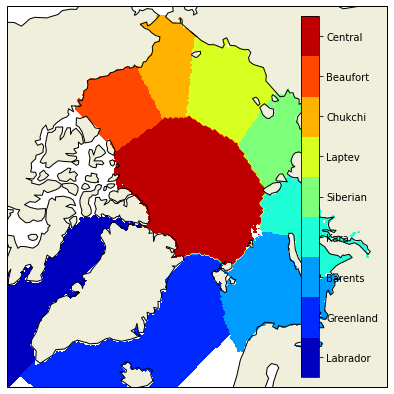

In [44]:
### various regional masking options
Nmask2 = GN2G.rg_array(Nmask,method='nearest')

regions = [
#     {'N_ints':[8,9,10,11,12,13,15],'label':'Basin'},
#     {'N_ints':[6,7,8,9,10,11,12,13,15],'label':'System'},### need to mod 6,7 to be above 60N
    #### reduced 1
#     {'N_ints':[15],'label':'Central'},
#     {'N_ints':[12,13],'label':'N. American'},
#     {'N_ints':[9,10,11],'label':'European'},
#     {'N_ints':[7,8],'label':'N. Atlantic'},
    #### All basin
    {'N_ints':[6,7,8,9,10,11,12,13,15],'label':'All'},
    {'N_ints':[6],'label':'Labrador'},
    {'N_ints':[7],'label':'Greenland'},
    {'N_ints':[8],'label':'Barents'},
    {'N_ints':[9],'label':'Kara'},
    {'N_ints':[10],'label':'Siberian'},
    {'N_ints':[11],'label':'Laptev'},
    {'N_ints':[12],'label':'Chukchi'},
    {'N_ints':[13],'label':'Beaufort'},
    {'N_ints':[15],'label':'Central'},
#     {'N_ints':[9,12,13],'label':'Seasonal'},
#     {'N_ints':[10,11],'label':'Factories'},
]

### all
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
p_rg = np.zeros_like(Nmask2)*np.nan
for pn,rg in enumerate(regions[1:]):
     p_rg[np.isin(Nmask2,rg['N_ints'])] = pn
s = ax.contourf(G.xpts, G.ypts,p_rg,
               cmap='jet',
#                 vmin = 0.0,vmax=4.0)
                levels = np.arange(-0.5,len(regions)-0.5))
# s = ax.contourf(G.xpts, G.ypts,Nmask2,levels=AllIce)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
cax = plt.colorbar(s,  pad=-0.22,shrink= 0.95)
cax.set_ticks(np.arange(len(regions)))
cax.set_ticklabels([rg['label'] for rg in regions[1:]])
# fig.savefig(save_dir+'Regions_map_all.png',bbox_inches='tight')

In [12]:
!ls Outputs/*.nc

Outputs/CMIP_proc_CESM2_r4i1p1f1_ssp585_2015_2016.nc
Outputs/CMIP_proc_CanESM5_r1i1p2f1_ssp585_2015_2016.nc


In [13]:
files = glob.glob('Outputs/*.nc')
files.sort()

In [22]:
### load all files into list of dictionaries
Clist = []
for file in files:
    Cmp = {}
    Cmp['vars'] = []
    print(file)
    f_nc = Dataset(file)
    for k in f_nc.variables.keys():
        Cmp[k] = f_nc.variables[k][:]
        Cmp['vars'].append(k)
    Cmp['centre'] = f_nc.CMIP6_model
    Cmp['name'] = f_nc.CMIP6_name
    Cmp['ensemble'] = f_nc.CMIP6_ensemble
    f_nc.close()
    
    Cmp['dtime'] = [dt.datetime(2000,1,1) + relativedelta(days=int(t)) for t in Cmp['time']]
    Clist.append(Cmp)

Outputs/CMIP_proc_CESM2_r4i1p1f1_ssp585_2015_2016.nc
Outputs/CMIP_proc_CanESM5_r1i1p2f1_ssp585_2015_2016.nc


/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if sys.path[0] == '':
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  del sys.path[0]


In [26]:
### makes a table, copy paste it into a tex file
from tabulate import tabulate

rows = [[Cmp['centre'],Cmp['name'],Cmp['ensemble']] for Cmp in Clist]

print(tabulate(rows,
           headers=['Centre','Model','Ensemble']
               , tablefmt='latex'))

\begin{tabular}{lll}
\hline
 Centre   & Model   & Ensemble   \\
\hline
 NCAR     & CESM2   & r4i1p1f1   \\
 CCCma    & CanESM5 & r1i1p2f1   \\
\hline
\end{tabular}


In [27]:
### check what we have 1
[c for c in Cmp.keys() ]# if 'ice_area_series' in v]

['vars',
 'ice_concentration',
 'lon',
 'lat',
 'time',
 'centre',
 'name',
 'ensemble',
 'dtime']

In [28]:
### check what we have 2
[Cmp['name'] for Cmp in Clist]# if 'ice_area_series' in v]

['CESM2', 'CanESM5']

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/opt/miniconda3/envs/harry/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


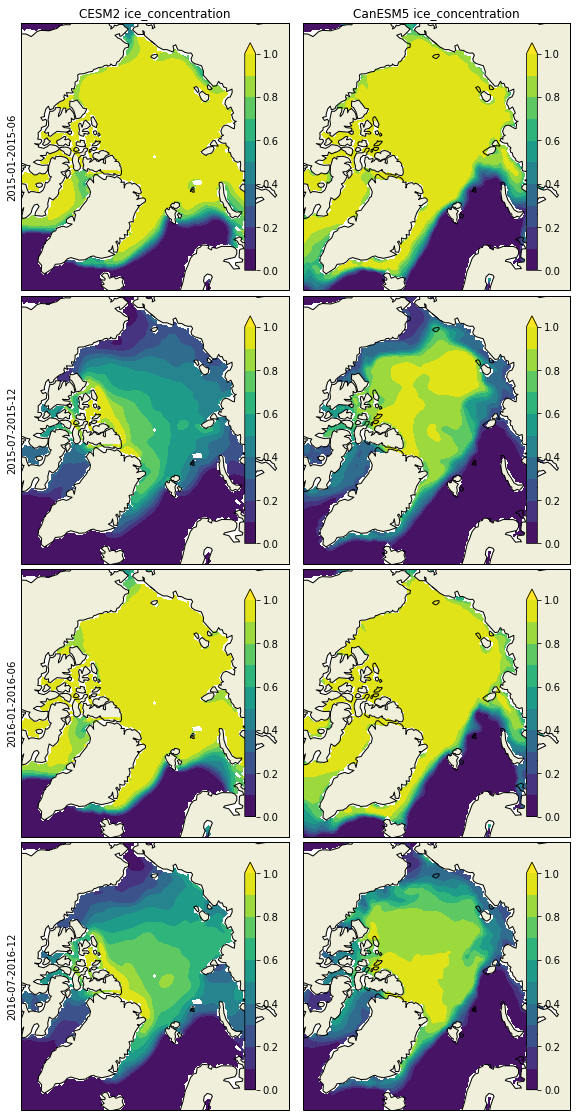

Outputs/CESM2_CanESM5_ice_concentration_6times_0_18_maps.png


In [64]:
#### plot onset days for each lim
pvar = [
'ice_concentration',
]
### set months to plot
## here stepping every 6 months
trange= 6
times = np.arange(0,24,trange)
### this code just plots a certain month
nrows = len(times)
ncols = len(pvar)*len(Clist)
fig = plt.figure(figsize=(5*ncols,5*nrows))
### columns
blevels = np.arange(0,1.1,0.1)
bs0 = blevels[0]
bs1 = blevels[-1]
for en,Cmp in enumerate(Clist):
    for pn,p in enumerate(pvar):
        data = Cmp[p].copy()
        data.mask = data>360
#         bmax = np.nanpercentile(data,97)
#         blevels = np.arange(0,bmax,10)
#         bs0 = blevels[0]
#         bs1 = blevels[-1]
#         ### rows
        for yn,y in enumerate(times):
            yp = slice(y,y+trange)
            an = 1 + ncols*yn + en*len(pvar) + pn
            ax = fig.add_subplot(nrows,ncols,an,projection=G.ccrs)
            ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
            temp_plot = np.nanmean(data[yp],axis=0)
            s = ax.contourf(G.xpts, G.ypts, temp_plot, vmin=bs0, 
                        vmax=bs1,levels=blevels, extend='max',
                            cmap=plt.cm.viridis)
#                             cmap=plt.cm.tab10)
#                             cmap=plt.cm.cubehelix)
            ax.add_feature(cfeature.LAND)
            ax.add_feature(cfeature.COASTLINE)
#             pdate0 = Edy.dates[Edy.yrpd[yp[0],month]]
#             pdate1 = Edy.dates[Edy.yrpd[yp[1],month]]
            if yn == 0:
                ax.set_title(Cmp['name']+' '+p)
            if pn == 0 and en==0:
                ax.set_ylabel(Cmp['dtime'][y].strftime('%Y-%m')+'-'+Cmp['dtime'][y+trange-1].strftime('%Y-%m'))
                ax.set_yticks([])

    #             print(pdate.strftime('%Y'))
            cax = plt.colorbar(s,  pad=-0.159,shrink= 0.85)
            cax.ax.yaxis.set_ticks_position('right')

fig.subplots_adjust(wspace=0.02, hspace=0.02)
pname = save_dir+'_'.join([e['name'].replace(' ','_') for e in Clist]+pvar+[str(trange)+'times',str(times[0]),str(times[-1]),'maps.png'])
# fig.savefig(pname,bbox_inches='tight')
plt.show()
print(pname)

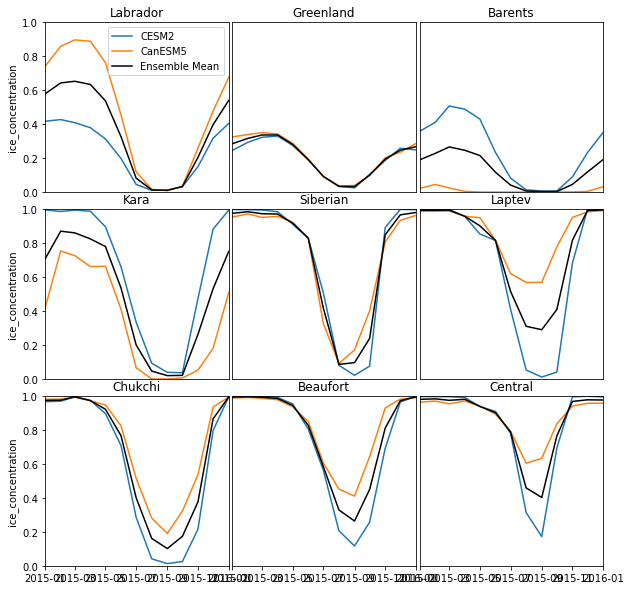

Outputs/CESM2_CanESM5_ice_concentration_1years_2015_2016_maps.png


In [47]:
### for each region average of each variable
pvar = [
'ice_concentration',
]
fig = plt.figure(figsize=(10,10))
for pn,rg in enumerate(regions[1:]):
#     ax = fig.add_subplot(2,2,pn+1)
    ax = fig.add_subplot(3,3,pn+1)
    ensmb_mean = []
    for en,Cmp in enumerate(Clist):
#     for pn,p in enumerate(pvar):
        p = pvar[0]
        data = Cmp[p].copy()
        data.mask = np.isnan(data)
        data.mask[np.ones_like(data,dtype=bool)*~np.isin(Nmask2,rg['N_ints'])[None,:,:]] = True
        ax.plot_date(Cmp['dtime'],data.mean(axis=(1,2)),label = Cmp['name'],linestyle='-', marker='')
    #             print(pdate.strftime('%Y'))
        ensmb_mean.append(data.mean(axis=(1,2)))
    ax.plot_date(Cmp['dtime'],np.nanmean(ensmb_mean,axis=0),label = 'Ensemble Mean',
                 linestyle='-', marker='',color = 'k')
    ## all
    if np.isin(pn,[0,3,6]): 
        ax.set_ylabel(p)
    else: ax.set_yticks([])
    if pn<6: ax.set_xticks([])
#         if pn == 0: ax.legend(['Daily onset (RM)','Daily onset (linear)','Monthly est.',])
    if pn == 0: ax.legend()
#         ax.set_ylim(minmax)
    ax.set_xlim([dt.datetime(2015,1,1),dt.datetime(2016,1,1)]) ### 1.78
    ax.set_ylim([0,1.0]) ### 1.78
    ax.set_title(rg['label'])

fig.subplots_adjust(wspace=0.02, hspace=0.1)
# pname = save_dir+'_'.join([e['name'].replace(' ','_') for e in ECLs]+pvar+['onset_lines_regions.png'])
# fig.savefig(pname,bbox_inches='tight')
plt.show()
print(pname)

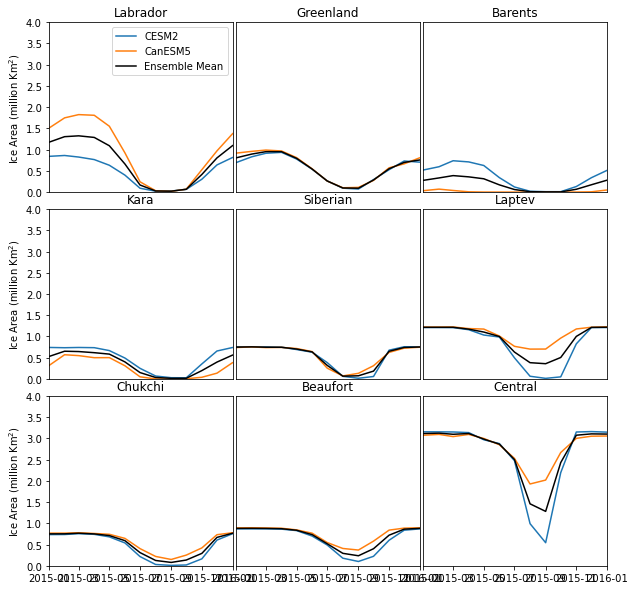

Outputs/CESM2_CanESM5_ice_concentration_6times_0_18_maps.png


In [77]:
### for each region sum of each variable (for ice area)
pscale = 1e-12 ##(m2 to million km2)
pvar = [
'ice_concentration',
]
fig = plt.figure(figsize=(10,10))
for pn,rg in enumerate(regions[1:]):
#     ax = fig.add_subplot(2,2,pn+1)
    ax = fig.add_subplot(3,3,pn+1)
    ensmb_mean = []
    for en,Cmp in enumerate(Clist):
#     for pn,p in enumerate(pvar):
        p = pvar[0]
        data = Cmp[p].copy()*G.xdist[None,:,:]*G.ydist[None,:,:]*pscale
        data.mask = np.isnan(data)
        data.mask[np.ones_like(data,dtype=bool)*~np.isin(Nmask2,rg['N_ints'])[None,:,:]] = True
        data_plot = np.nansum(data,axis=(1,2))
        ax.plot_date(Cmp['dtime'],data_plot,label = Cmp['name'],linestyle='-', marker='')
    #             print(pdate.strftime('%Y'))
        ensmb_mean.append(data_plot)
    ax.plot_date(Cmp['dtime'],np.nanmean(ensmb_mean,axis=0),label = 'Ensemble Mean',
                 linestyle='-', marker='',color = 'k')
    ## all
    if np.isin(pn,[0,3,6]): 
        ax.set_ylabel('Ice Area (million Km$^2$)')
    else: ax.set_yticks([])
    if pn<6: ax.set_xticks([])
#         if pn == 0: ax.legend(['Daily onset (RM)','Daily onset (linear)','Monthly est.',])
    if pn == 0: ax.legend()
#         ax.set_ylim(minmax)
    ax.set_xlim([dt.datetime(2015,1,1),dt.datetime(2016,1,1)]) ### 1.78
    ax.set_ylim([0,4.0]) ### 1.78
    ax.set_title(rg['label'])

fig.subplots_adjust(wspace=0.02, hspace=0.1)
# pname = save_dir+'_'.join([e['name'].replace(' ','_') for e in ECLs]+pvar+['onset_lines_regions.png'])
# fig.savefig(pname,bbox_inches='tight')
plt.show()
print(pname)

In [57]:
### make a summary file 
#### for each Ecl
for Cmp,f in zip(Clist,files):
    ### make a file name
    fnew = f.split('.nc')[0]+'_summary.nc'
    NC_f = Dataset(fnew, 'w', format='NETCDF4')
    NC_f.createDimension('time', len(Cmp['time']))
    NC_f.createVariable('time', int,('time'))
    NC_f.variables['time'][:] = Cmp['time']
    ### for the following variables
    v_sum = [
        'ice_concentration',
    ]
    for p in v_sum:
        ### select the variable
        ### for each region
        for rg in regions:
            data = Cmp[p].copy()
            ### make the series
            data.mask = np.isnan(data)
            data.mask[np.ones_like(data,dtype=bool)*~np.isin(Nmask2,rg['N_ints'])[None,:,:]] = True
            x = data.mean(axis=(1,2))
            ### make the variable name
            v_new = p+'_'+rg['label']
            ### save it
            NC_f.createVariable(v_new, float,('time'))
            NC_f.variables[v_new][:] = x
    ## close the file
    NC_f.close()
            
        
        